In [4]:
import scipy.optimize as op
import numpy as np
import matplotlib.pyplot as plt
import math
import random

**Descargamos datos:**

In [5]:
file = np.load('fit_ejercise.npy')

In [16]:
x = file[0]
y = file[1]
yerror = file[2]

data = file

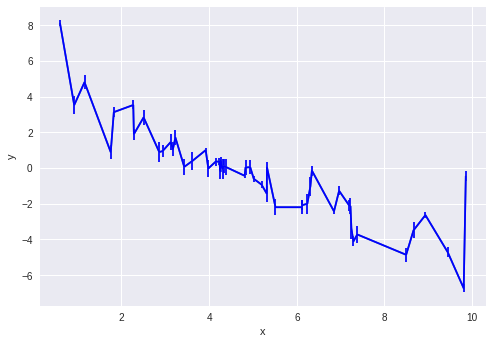

In [17]:
plt.style.use('seaborn')
plt.plot(x, y)
plt.errorbar(x, y,yerr = yerror, markersize = 0.5, fmt = 'blue')
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

In [95]:
def line(m, b,x):
    return m*x + b

def chisq(theta, data):
    m = theta[0]
    b = theta[1]
    f = np.exp(2*theta[2])
    model = line(m,b,data[0])
    sigma2 = (data[2]**2+f*(model)**2)
    chisq = (data[1]-model)**2/sigma2 + np.log(sigma2)
    return chisq.sum()

In [96]:
np.log(1)

0.0

In [97]:
chisq([-1,4,np.log(0.1)], data)

455.6402926097669

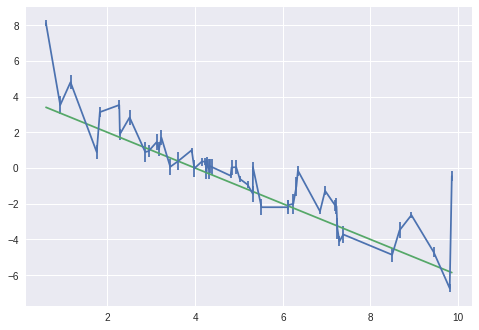

In [98]:
plt.errorbar(x, y, yerr = yerror)
plt.plot(data[0], line(-1,4,data[0]))

In [99]:
ini_point = (-2,4,0.1)

chisq_ = lambda *args: chisq(*args)


min_sol = op.minimize(chisq_, ini_point, args = data, method = 'L-BFGS-B', bounds=((-10,10),(0,10),(-6,1)))

In [100]:
min_sol

      fun: 24.36482789608832
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.10898007e-04, -1.89359639e-04,  3.44613227e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 19
   status: 0
  success: True
        x: array([-1.00300809,  4.52831212, -0.79043962])

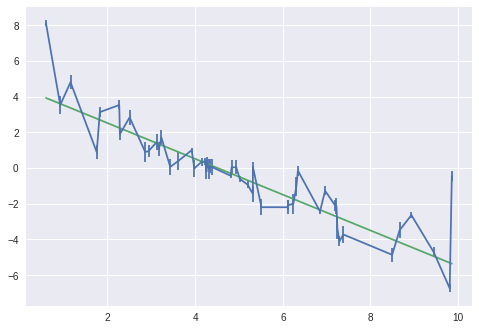

In [101]:
plt.errorbar(x, y, yerr = yerror)
plt.plot(data[0], line(min_sol.x[0], min_sol.x[1], data[0]))

In [103]:
np.exp(-0.79)

0.45384479528235583

**Ahora con PowerSpectrum**

In [104]:
from colossus.cosmology import cosmology

In [105]:
cosmo = cosmology.setCosmology('planck15')
print(cosmo)

Cosmology "planck15" 
    flat = True, Om0 = 0.3089, Ode0 = 0.6910, Ob0 = 0.0486, H0 = 67.74, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [108]:
pk_cmasdr12 = np.loadtxt('GilMarin_2016_CMASSDR12_measurement_monopole_post_recon.txt').T

In [110]:
def Pk_Om(Om_,b,beta,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+beta)*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

In [126]:
def chisq(theta,data): # Función que calcula el logaritmo natural del likelihood
    Om = theta[0]
    b = theta[1]
    beta = theta[2]
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, beta,equis) # Calculamos el modelo utilizando la función Pk_om
    chisq2 = (ye-model)**2/(yerr**2) #+ np.log(yerr**2) # Obtenemos chi^2
    return chisq2.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

In [127]:
chisq([0.3,1,np.log(0.1)], data)

431414.7240671801

In [130]:
ini_point = (0.3,1.6,0.1)

#chisq_ = lambda *args: chisq(*args)
data = pk_cmasdr12

min_sol = op.minimize(chisq, ini_point, args = data, method = 'L-BFGS-B', bounds=((0,1),(0,5),(0,1)))

In [131]:
min_sol

      fun: 1516.6063938833963
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.00031832, -0.00015916])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 5
   status: 0
  success: True
        x: array([0.3       , 1.9145828 , 0.18428751])

In [134]:
np.random.seed(1) # Semilla para los números aleatorios.
x = pk_cmasdr12[0][15:45] # Quitamos los datos del inicio que no se ajustan a ningún modelo del matterPowerSpectrum
y = pk_cmasdr12[1][15:45]
yerror = pk_cmasdr12[2][15:45]

Om_total = [] # Declaramos Om_total, que es donde se guardarán los valores de Om0 para cada camino
b_total = [] # Lo mismo para el bias. 
beta_total = []

sigma = 0.01 # Desviación estándar de la distribución gaussiana de números aleatorios.
rango = 500

for k in range(5): # 5 caminos
    Om_0 = np.random.normal(min_sol.x[0], 0.03, 10) # Los valores iniciales para cada camino se generarán con números aleatorios de una distribución uniforme
    b0 = np.random.normal(min_sol.x[1], 0.18, 10) # Lo mismo para el bias
    beta0 = np.random.uniform(min_sol.x[2], 0.01, 10) # Lo mismo para beta
    Om_sample = [Om_0[k]] # Guardamos el valor inicial para Om0 del camino k
    b_sample = [b0[k]] # Guardamos el valor inicial para el bias del camino k
    beta_sample = [beta0[k]] # Guardamos el valor inicial para el Beta del camino k
    lnlike0 = -1*chisq([Om_0[k], b0[k], beta0[k]],[x,y,yerror]) # Calculamos el logaritmo natural del likelihood inicial para cada camino
    for j in range(1,rango):
        Om_new = np.random.normal(Om_sample[len(Om_sample)-1], sigma) # Obtenemos un nuevo valor para Om0
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma) # Obtenemos un nuevo valor para b
        beta_new = np.random.normal(beta_sample[len(beta_sample)-1], sigma) # Obtenemos un nuevo valor para beta
        if Om_new <= 0.5 and Om_new >= 0.1 and b_new <= 2.2 and b_new >= 1.5 and beta_new >= 0 and beta_new <=0.5: # Prior
            like = -1*chisq([Om_new, b_new, beta_new],[x,y,yerror]) # Prior
            if like>lnlike0: # Si el nuevo ln de L es mayor que el anterior, se acepta
                lnlike0 = like
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
            elif lnlike0-like<-math.log(random.uniform(0,1)): # Si la diferencia es menor que el logaritmo de un número aleatorio en 0 y 1 se acepta
                lnlike0 = like 
                Om_sample.append(Om_new) # Se guarda el nuevo valor de Om0 para el camino k
                b_sample.append(b_new) # Lo mismo para b
                beta_sample.append(beta_new)
    Om_total.append(Om_sample) # Se guardan los valores de Om0 del camino k en m_total
    b_total.append(b_sample)
    beta_total.append(beta_sample)

Text(0.5, 0, '$beta$')

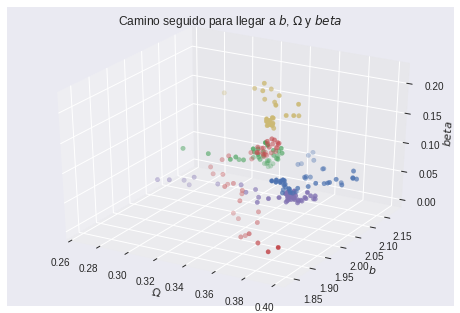

In [135]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

for i in range(len(Om_total)):
    ax1.scatter(Om_total[i], b_total[i], beta_total[i])


ax1.set_title('Camino seguido para llegar a $b$, $\Omega$ y $beta$')
ax1.set_xlabel('$\Omega$')
ax1.set_ylabel('$b$')
ax1.set_zlabel('$beta$')

## Utilizando emcee

In [202]:
import emcee
import tqdm

In [223]:
def Pk_Om(Om_,b,beta,k):
    cosmo = cosmology.setCosmology('planck15') # Generamos los parámetros default del experimento planck15
    z = 0.57 
    cosmo.Om0 = Om_ # Modificamos la densidad de materia
    return b**2*(1+beta)*cosmo.matterPowerSpectrum(k,z) # Se regresa la función matterPowerSpectrum multiplicada por el bias al cuadrado

In [221]:
def log_likelihood(theta,data): # Función que calcula el logaritmo natural del likelihood
    Om = theta[0]
    b = theta[1]
    beta = theta[2]
    equis = data[0] # Llamamos x al primer conjunto de datos
    ye = data[1] # Llamamos y al segundo conjunto de datos
    yerr = data[2]  # Llamamos yerror al tercer conjunto de datos
    model = Pk_Om(Om, b, beta,equis) # Calculamos el modelo utilizando la función Pk_om
    chisq2 = (ye-model)**2/(yerr**2) + np.log(yerr**2) # Obtenemos chi^2
    return chisq2.sum() # Regresamos la suma de todos los chi^2, que da como resultado el ln del likelihood.

In [224]:
log_likelihood([0.4, 2, 1.6], data)

407868.79050895013

In [205]:
np.random.seed(42)

In [206]:
ini_point = (0.3,1.6,0.1)

#chisq_ = lambda *args: chisq(*args)
data = pk_cmasdr12

min_sol = op.minimize(log_likelihood, ini_point, args = data, method = 'L-BFGS-B', bounds=((0,1),(0,5),(0,1)))

In [207]:
min_sol

      fun: 2292.920841719619
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  4.54747351e-04, -9.09494702e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 5
   status: 0
  success: True
        x: array([0.3       , 1.9145828 , 0.18428751])

In [226]:
def log_prior(theta):
    Om0, b, beta = theta
    if 0.05 < Om0 < 0.5 and 0.1 < b < 2.1 and 0.05 < beta < 0.6:
        return 0.0
    return -np.inf

In [227]:
x, y, yerr = data[0], data[1], data[2]
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, [x, y, yerr])

In [228]:
pos = min_sol.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

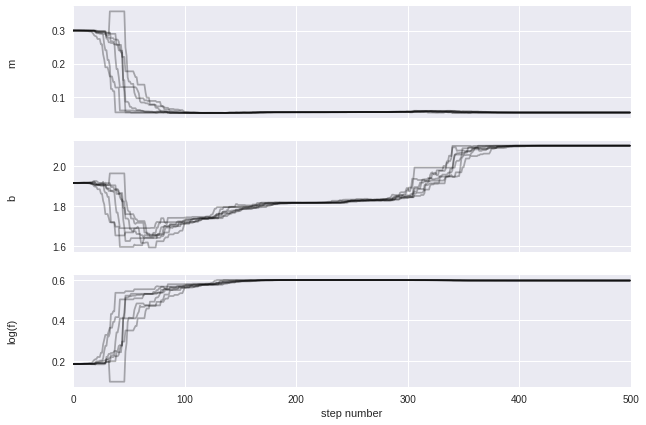

In [233]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [230]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(182, 3)


<function matplotlib.pyplot.show(*args, **kw)>

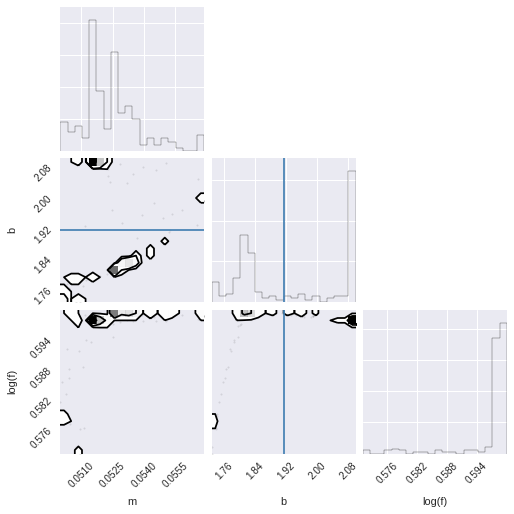

In [234]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=min_sol.x
);
plt.show